# Interpret with IEMSO 

In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings("ignore")

def CR(objective_values):
    T = len(objective_values)
    if T < 2:
        raise ValueError("The number of iterations must be at least 2 to calculate CR.")
    
    cr = np.mean([(objective_values[t-1] - objective_values[t]) / objective_values[t-1] for t in range(1, T)])
    return cr

def calculate_cr_in_segments(data, segment_size):
    num_segments = len(data) // segment_size
    cr_values = []
    
    for i in range(num_segments):
        segment = data[0:(i+1)*segment_size]
        if len(segment) > 1:
            cr = CR(segment)
            cr_values.append(cr)
    
    return cr_values

def compute_optimization_stability(final_objective_values):

    final_objective_values = np.array(final_objective_values)
    mean_value = np.mean(final_objective_values)
    std_dev = np.std(final_objective_values, ddof=0)  # Population standard deviation
    #OS = std_dev / mean_value if mean_value != 0 else float('inf')  # Avoid division by zero
    return std_dev #OS

def calculate_os_in_segments(values, segment_size):
    values = np.array(values)
    num_segments = len(values) // segment_size
    os_list = []

    for i in range(num_segments):
        segment = values[0:(i + 1) * segment_size]
        os = compute_optimization_stability(segment)
        os_list.append(os)

    return os_list

import numpy as np
from sklearn.neighbors import KernelDensity
from itertools import combinations
import pandas as pd 
import csv

def entropy(points):
    # Fit a Kernel Density Estimation (KDE) model
    kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
    kde.fit(points)

    # Compute entropy
    log_density = kde.score_samples(points)  # Log-density of each point
    ent = -np.mean(log_density)
    
    #Entropy values are typically positive and can vary widely (no upper bound) depending on the spread 
    #and concentration of the probability density function. 
    
    return ent 

def similarity(x, y, sigma=1.0):
    return np.exp(-0.5 * np.sum((x - y)**2) / sigma**2) #x @ y.T


def L_det(points):
    # Compute the kernel matrix L based on pairwise similarities
    n_points = len(points)
    L = np.zeros((n_points, n_points))
    for i in range(n_points):
        for j in range(n_points):
            L[i, j] = similarity(points[i], points[j])
    # Compute the determinant of the kernel matrix L
    determinant = np.linalg.det(L)

    return determinant

def average_pairwise_distance(S, X):
    distances = []
    for s in S:
        min_distance = np.min(np.linalg.norm(X - s, axis=1))
        distances.append(min_distance)
    return np.mean(distances)

def simplex_volume(points):
    points = np.array(points)
    d = points.shape[1]
    mat = points[1:] - points[0]
    return np.abs(np.linalg.det(mat)) / np.math.factorial(d)

def hypervolume(points):
    points = np.array(points)
    n, d = points.shape
    #print(n,d)
    if n <= d:
        raise ValueError("The number of points must be greater than the dimensionality of the space.")
    
    # Define the reference point (0, 0, ..., 0)
    reference_point = np.zeros(d)
    
    # Compute the hypervolume as the sum of the volumes of the simplices formed with the reference point
    hypervolume = 0
    for subset in combinations(points, d):
        vertices = np.vstack([subset, reference_point])
        hypervolume += simplex_volume(vertices)
    
    return hypervolume



## Reading the results of optimization 

In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

def read_values(ys,nn,batch_size,init_size,d):
    f_val=[]
    aq_val_mean=[]
    aq_val_std=[]
    dpp_det=[]
    ent=[]
    dist=[]
    hv=[]
    bks=[]
    bb=1000000
    scaler = MinMaxScaler()
    ys2= scaler.fit_transform(ys)
    ys2=pd.DataFrame(ys2)
    #print(ys2)
    for i in range(nn-1):
        aqs= ys[i*batch_size:batch_size*(i+1)]['acquisition_value']
        ff=ys[i*batch_size:batch_size*(i+1)]['f(x)']
        sample_points=ys2.iloc[i*batch_size:batch_size*(i+1),0:d]
        #print(sample_points)
        aq_val_mean.append(aqs.mean())
        aq_val_std.append(aqs.std())
        f_val.append(ff.min())
        dpp_det.append(L_det(sample_points))
        ent.append(entropy(sample_points))

        #average pairwise distance
        X=ys.iloc[0:init_size+batch_size*(i),0:d]
        S=ys.iloc[init_size+batch_size*(i):init_size+batch_size*(i+1),0:d]
        dist.append(average_pairwise_distance(np.array(S), np.array(X)))

        #hv exploration-exploitation 
        sample_points2= ys2.iloc[init_size+batch_size*(i):init_size+batch_size*(i+1),d+2:d+4]
        sample_points2.iloc[:,0]=-sample_points2.iloc[:,0]
        #print(sample_points2)
        bb=min(ff.min(),bb)#ys.iloc[init_size+batch_size*(i):init_size+batch_size*(i+1),d+4]
        #print(bb)
        hv.append(hypervolume(sample_points2))
        bks.append(bb)
    
    
    f_val= np.array(f_val)
    aq_mean = np.array(aq_val_mean) 
    aq_std= np.array(aq_val_std) 
    det = np.array(dpp_det)
    ent = np.array(ent)
    dist = np.array(dist)
    hv = np.array(hv)
    bks = np.array(bks)#.reshape((nn-1)*batch_size)
    
    return aq_mean,aq_std,det,ent,dist,hv,bks 

In [11]:
d=6
path=wd+'/'
Name='Levy'
ei=pd.read_csv(path+Name+'_'+str(d)+'d_EI_1.csv')
ucb=pd.read_csv(path+Name+'_'+str(d)+'d_UCB_1.csv')
gibbon=pd.read_csv(path+Name+'_'+str(d)+'d_Gibbon_1.csv')
mes=pd.read_csv(path+Name+'_'+str(d)+'d_MES_1.csv')
deepa=pd.read_csv(wd+'/Deepa/Levy_6d_DEEPA_1.csv')
N=ei.shape[0]
Budget=400
batch_size=4
init_size=2*(d+1)
nn=int((N-init_size)/batch_size)


ei_aq_mean,ei_aq_std,ei_det,ei_ent,ei_dist,ei_hv,ei_bks =read_values(ei,nn,batch_size,init_size,d)
ucb_aq_mean,ucb_aq_std,ucb_det,ucb_ent,ucb_dist,ucb_hv,ucb_bks =read_values(ucb,nn,batch_size,init_size,d)
gibbon_aq_mean,gibbon_aq_std,gibbon_det,gibbon_ent,gibbon_dist,gibbon_hv,gibbon_bks =read_values(gibbon,nn,batch_size,init_size,d)
mes_aq_mean,mes_aq_std,mes_det,mes_ent,mes_dist,mes_hv,mes_bks =read_values(mes,nn,batch_size,init_size,d)
deepa_aq_mean,deepa_aq_std,deepa_det,deepa_ent,deepa_dist,deepa_hv,deepa_bks =read_values(mes,nn,batch_size,init_size,d)



In [12]:
import os 
wd=os.getcwd()


def L_det(points):
    # Compute the kernel matrix L based on pairwise similarities
    n_points = len(points)
    L = np.zeros((n_points, n_points))
    #for i in range(n_points):
        #for j in range(n_points):
            #L[i, j] = similarity(points[i], points[j])
    # Compute the determinant of the kernel matrix L
    #determinant = np.linalg.det(L)

    return None

d=2
path=wd+'/Rosenbrock_result1/'
Name='Rosen'
ei=pd.read_csv(path+Name+'_'+str(d)+'d_EI.csv')
ucb=pd.read_csv(path+Name+'_'+str(d)+'d_UCB.csv')
gibbon=pd.read_csv(path+Name+'_'+str(d)+'d_Gibbon.csv')
mes=pd.read_csv(path+Name+'_'+str(d)+'d_MES.csv')
deepa=pd.read_csv(path+Name+'_'+str(d)+'d_DEEPA.csv')
N=ei.shape[0]
Budget=80
batch_size=4
nn=int(N/batch_size)
init_size=2*(d+1)


ei_aq_mean,ei_aq_std,ei_det,ei_ent,ei_dist,ei_hv,ei_bks =read_values(ei,nn,batch_size,init_size,d)
ucb_aq_mean,ucb_aq_std,ucb_det,ucb_ent,ucb_dist,ucb_hv,ucb_bks =read_values(ucb,nn,batch_size,init_size,d)
gibbon_aq_mean,gibbon_aq_std,gibbon_det,gibbon_ent,gibbon_dist,gibbon_hv,gibbon_bks =read_values(gibbon,nn,batch_size,init_size,d)
mes_aq_mean,mes_aq_std,mes_det,mes_ent,mes_dist,mes_hv,mes_bks =read_values(mes,nn,batch_size,init_size,d)
deepa_aq_mean,deepa_aq_std,deepa_det,deepa_ent,deepa_dist,deepa_hv,deepa_bks =read_values(deepa,nn,batch_size,init_size,d)


In [13]:
import os
import pandas as pd 

wd=os.getcwd()

ei_1=pd.read_csv(wd+'/Levy_6d_EI_1.csv')
ucb_1=pd.read_csv(wd+'/Levy_6d_UCB_1.csv')
gibbon_1=pd.read_csv(wd+'/Levy_6d_Gibbon_1.csv')
mes_1=pd.read_csv(wd+'/Levy_6d_MES_1.csv')

ei_2=pd.read_csv(wd+'/Levy_6d_EI_2.csv')
ucb_2=pd.read_csv(wd+'/Levy_6d_UCB_2.csv')
gibbon_2=pd.read_csv(wd+'/Levy_6d_Gibbon_2.csv')
mes_2=pd.read_csv(wd+'/Levy_6d_MES_2.csv')

ei_3=pd.read_csv(wd+'/Levy_6d_EI_3.csv')
ucb_3=pd.read_csv(wd+'/Levy_6d_UCB_3.csv')
gibbon_3=pd.read_csv(wd+'/Levy_6d_Gibbon_3.csv')
mes_3=pd.read_csv(wd+'/Levy_6d_MES_3.csv')

ei_4=pd.read_csv(wd+'/Levy_6d_EI_4.csv')
ucb_4=pd.read_csv(wd+'/Levy_6d_UCB_4.csv')
gibbon_4=pd.read_csv(wd+'/Levy_6d_Gibbon_4.csv')
mes_4=pd.read_csv(wd+'/Levy_6d_MES_4.csv')

ei_5=pd.read_csv(wd+'/Levy_6d_EI_5.csv')
ucb_5=pd.read_csv(wd+'/Levy_6d_UCB_5.csv')
gibbon_5=pd.read_csv(wd+'/Levy_6d_Gibbon_5.csv')
mes_5=pd.read_csv(wd+'/Levy_6d_MES_5.csv')

deepa_1=pd.read_csv(wd+'/Deepa/Levy_6d_DEEPA_1.csv')
deepa_2=pd.read_csv(wd+'/Deepa/Levy_6d_DEEPA_2.csv')
deepa_3=pd.read_csv(wd+'/Deepa/Levy_6d_DEEPA_3.csv')
deepa_4=pd.read_csv(wd+'/Deepa/Levy_6d_DEEPA_4.csv')
deepa_5=pd.read_csv(wd+'/Deepa/Levy_6d_DEEPA_5.csv')

## Optimization Process Metrics

In [14]:
def compute_mean_and_range(y1, y2, y3, y4, y5):
    y_values = np.vstack([y1, y2, y3, y4, y5])
    y_mean = np.mean(y_values, axis=0)
    y_min = np.min(y_values, axis=0)
    y_max = np.max(y_values, axis=0)
    return y_mean, y_min, y_max

(12,) 12


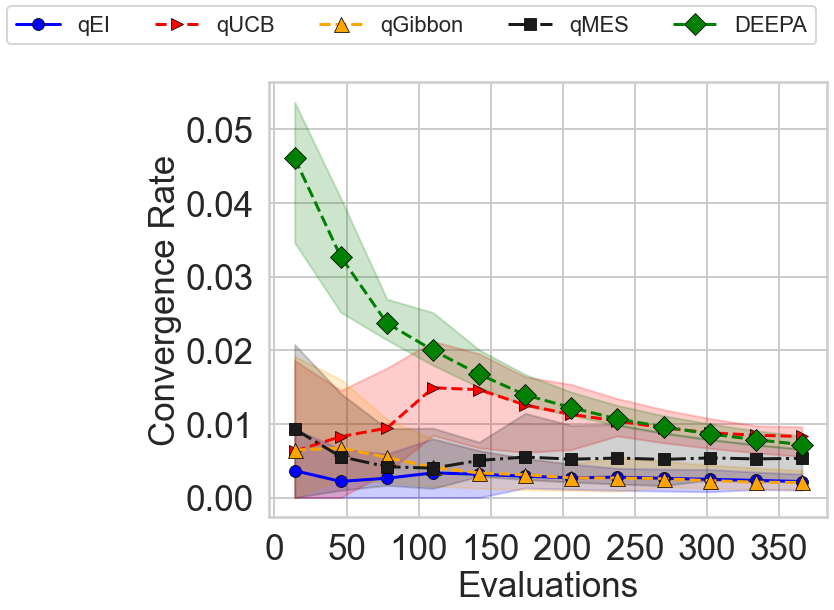

In [15]:
bb=16*2

ei_cr1=calculate_cr_in_segments(np.array(ei_1.iloc[:,-1]),bb)
ei_cr2=calculate_cr_in_segments(np.array(ei_2.iloc[:,-1]),bb)
ei_cr3=calculate_cr_in_segments(np.array(ei_3.iloc[:,-1]),bb)
ei_cr4=calculate_cr_in_segments(np.array(ei_4.iloc[:,-1]),bb)
ei_cr5=calculate_cr_in_segments(np.array(ei_5.iloc[:,-1]),bb)

ucb_cr1=calculate_cr_in_segments(np.array(ucb_1.iloc[:,-1]),bb)
ucb_cr2=calculate_cr_in_segments(np.array(ucb_2.iloc[:,-1]),bb)
ucb_cr3=calculate_cr_in_segments(np.array(ucb_3.iloc[:,-1]),bb)
ucb_cr4=calculate_cr_in_segments(np.array(ucb_4.iloc[:,-1]),bb)
ucb_cr5=calculate_cr_in_segments(np.array(ucb_5.iloc[:,-1]),bb)

gibbon_cr1=calculate_cr_in_segments(np.array(gibbon_1.iloc[:,-1]),bb)
gibbon_cr2=calculate_cr_in_segments(np.array(gibbon_2.iloc[:,-1]),bb)
gibbon_cr3=calculate_cr_in_segments(np.array(gibbon_3.iloc[:,-1]),bb)
gibbon_cr4=calculate_cr_in_segments(np.array(gibbon_4.iloc[:,-1]),bb)
gibbon_cr5=calculate_cr_in_segments(np.array(gibbon_5.iloc[:,-1]),bb)

mes_cr1=calculate_cr_in_segments(np.array(mes_1.iloc[:,-1]),bb)
mes_cr2=calculate_cr_in_segments(np.array(mes_2.iloc[:,-1]),bb)
mes_cr3=calculate_cr_in_segments(np.array(mes_3.iloc[:,-1]),bb)
mes_cr4=calculate_cr_in_segments(np.array(mes_4.iloc[:,-1]),bb)
mes_cr5=calculate_cr_in_segments(np.array(mes_5.iloc[:,-1]),bb)

deepa_cr1=calculate_cr_in_segments(np.array(deepa_1.iloc[:,-1]),bb)
deepa_cr2=calculate_cr_in_segments(np.array(deepa_2.iloc[:,-1]),bb)
deepa_cr3=calculate_cr_in_segments(np.array(deepa_3.iloc[:,-1]),bb)
deepa_cr4=calculate_cr_in_segments(np.array(deepa_4.iloc[:,-1]),bb)
deepa_cr5=calculate_cr_in_segments(np.array(deepa_5.iloc[:,-1]),bb)

# Calculate for the first set
y_mean1, y_min1, y_max1 = compute_mean_and_range(ei_cr1, ei_cr2, ei_cr3, ei_cr4, ei_cr5)
 
# Calculate for the second set
y_mean2, y_min2, y_max2 = compute_mean_and_range(ucb_cr1, ucb_cr2,ucb_cr3,ucb_cr4,ucb_cr5)

# Calculate for the third set
y_mean3, y_min3, y_max3 = compute_mean_and_range(gibbon_cr1,gibbon_cr2,gibbon_cr3,gibbon_cr4,gibbon_cr5)

# Calculate for the third set
y_mean4, y_min4, y_max4 = compute_mean_and_range(mes_cr1,mes_cr2,mes_cr3,mes_cr4,mes_cr5)

# Calculate for the third set
y_mean5, y_min5, y_max5 = compute_mean_and_range(deepa_cr1,deepa_cr2,deepa_cr3,deepa_cr4,deepa_cr5)

# Plotting
#plt.figure(figsize=(10, 6))

import seaborn as sns 

plt.rcParams.update({'font.size': 40})
#sns.set_context("talk", font_scale=10) 

xx=np.arange(14,406-14,bb)

print(xx.shape,len(y_mean1))

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.set_context("poster")

#sns.reset_defaults()
#print(y_mean1)
sns.lineplot(x=xx, y=y_mean1, marker='o', color='blue', linestyle='-', label='qEI',
            markersize=12, markeredgecolor='black')
plt.fill_between(x=xx, y1=y_min1, y2=y_max1, alpha=0.2, color='blue')


sns.lineplot(x=xx, y=y_mean2, marker='>', color='red', linestyle='--', label='qUCB',
            markersize=12, markeredgecolor='black')
plt.fill_between(x=xx, y1=y_min2, y2=y_max2, alpha=0.2, color='red')


sns.lineplot(x=xx, y=y_mean3, marker='^', color='orange', linestyle='--', label='qGibbon',
            markersize=15, markeredgecolor='black')
plt.fill_between(x=xx, y1=y_min3, y2=y_max3, alpha=0.2, color='orange')


sns.lineplot(x=xx, y=y_mean4, marker='s', color='k', linestyle='-.', label='qMES',
            markersize=12, markeredgecolor='black')
plt.fill_between(x=xx, y1=y_min4, y2=y_max4, alpha=0.2, color='k')


sns.lineplot(x=xx, y=y_mean5, marker='D', color='green', linestyle='--', label='DEEPA',
            markersize=15, markeredgecolor='black')
plt.fill_between(x=xx, y1=y_min5, y2=y_max5, alpha=0.2, color='green')


plt.xlabel('Evaluations',fontsize=35)
plt.ylabel('Convergence Rate',fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(fontsize=35)
#plt.legend(False)
plt.legend().remove()
plt.legend(bbox_to_anchor=(1,1.2),ncol=5)
plt.show()




(12,) 12


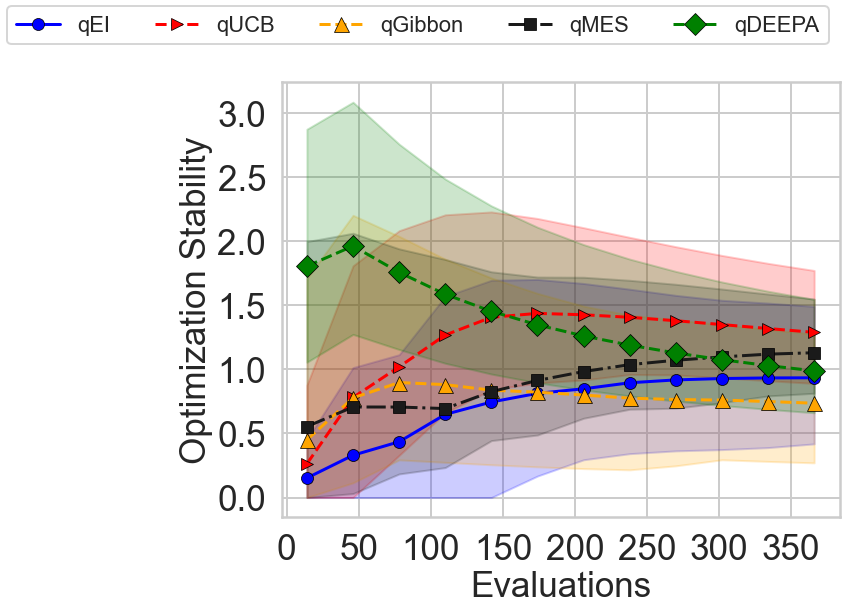

In [16]:

bb=16*2

ei_cr1=calculate_os_in_segments(np.array(ei_1.iloc[:,-1]),bb)
ei_cr2=calculate_os_in_segments(np.array(ei_2.iloc[:,-1]),bb)
ei_cr3=calculate_os_in_segments(np.array(ei_3.iloc[:,-1]),bb)
ei_cr4=calculate_os_in_segments(np.array(ei_4.iloc[:,-1]),bb)
ei_cr5=calculate_os_in_segments(np.array(ei_5.iloc[:,-1]),bb)

ucb_cr1=calculate_os_in_segments(np.array(ucb_1.iloc[:,-1]),bb)
ucb_cr2=calculate_os_in_segments(np.array(ucb_2.iloc[:,-1]),bb)
ucb_cr3=calculate_os_in_segments(np.array(ucb_3.iloc[:,-1]),bb)
ucb_cr4=calculate_os_in_segments(np.array(ucb_4.iloc[:,-1]),bb)
ucb_cr5=calculate_os_in_segments(np.array(ucb_5.iloc[:,-1]),bb)

gibbon_cr1=calculate_os_in_segments(np.array(gibbon_1.iloc[:,-1]),bb)
gibbon_cr2=calculate_os_in_segments(np.array(gibbon_2.iloc[:,-1]),bb)
gibbon_cr3=calculate_os_in_segments(np.array(gibbon_3.iloc[:,-1]),bb)
gibbon_cr4=calculate_os_in_segments(np.array(gibbon_4.iloc[:,-1]),bb)
gibbon_cr5=calculate_os_in_segments(np.array(gibbon_5.iloc[:,-1]),bb)

mes_cr1=calculate_os_in_segments(np.array(mes_1.iloc[:,-1]),bb)
mes_cr2=calculate_os_in_segments(np.array(mes_2.iloc[:,-1]),bb)
mes_cr3=calculate_os_in_segments(np.array(mes_3.iloc[:,-1]),bb)
mes_cr4=calculate_os_in_segments(np.array(mes_4.iloc[:,-1]),bb)
mes_cr5=calculate_os_in_segments(np.array(mes_5.iloc[:,-1]),bb)

deepa_cr1=calculate_os_in_segments(np.array(deepa_1.iloc[:,-1]),bb)
deepa_cr2=calculate_os_in_segments(np.array(deepa_2.iloc[:,-1]),bb)
deepa_cr3=calculate_os_in_segments(np.array(deepa_3.iloc[:,-1]),bb)
deepa_cr4=calculate_os_in_segments(np.array(deepa_4.iloc[:,-1]),bb)
deepa_cr5=calculate_os_in_segments(np.array(deepa_5.iloc[:,-1]),bb)

# def compute_mean_and_range(y1, y2, y3, y4, y5):
#     y_values = np.vstack([y1, y2, y3, y4, y5])
#     y_mean = np.mean(y_values, axis=0)
#     y_min = np.min(y_values, axis=0)
#     y_max = np.max(y_values, axis=0)
#     return y_mean, y_min, y_max

# Calculate for the first set
y_mean1, y_min1, y_max1 = compute_mean_and_range(ei_cr1, ei_cr2, ei_cr3, ei_cr4, ei_cr5)
 
# Calculate for the second set
y_mean2, y_min2, y_max2 = compute_mean_and_range(ucb_cr1, ucb_cr2,ucb_cr3,ucb_cr4,ucb_cr5)

# Calculate for the third set
y_mean3, y_min3, y_max3 = compute_mean_and_range(gibbon_cr1,gibbon_cr2,gibbon_cr3,gibbon_cr4,gibbon_cr5)

# Calculate for the third set
y_mean4, y_min4, y_max4 = compute_mean_and_range(mes_cr1,mes_cr2,mes_cr3,mes_cr4,mes_cr5)

# Calculate for the third set
y_mean5, y_min5, y_max5 = compute_mean_and_range(deepa_cr1,deepa_cr2,deepa_cr3,deepa_cr4,deepa_cr5)

# Plotting
#plt.figure(figsize=(10, 6))

import seaborn as sns 

plt.rcParams.update({'font.size': 40})
#sns.set_context("talk", font_scale=10) 

xx=np.arange(14,406-14,bb)

print(xx.shape,len(y_mean1))

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.set_context("poster")

#sns.reset_defaults()
#print(y_mean1)
sns.lineplot(x=xx, y=y_mean1, marker='o', color='blue', linestyle='-', label='qEI',
            markersize=12, markeredgecolor='black')
plt.fill_between(x=xx, y1=y_min1, y2=y_max1, alpha=0.2, color='blue')


sns.lineplot(x=xx, y=y_mean2, marker='>', color='red', linestyle='--', label='qUCB',
            markersize=12, markeredgecolor='black')
plt.fill_between(x=xx, y1=y_min2, y2=y_max2, alpha=0.2, color='red')


sns.lineplot(x=xx, y=y_mean3, marker='^', color='orange', linestyle='--', label='qGibbon',
            markersize=15, markeredgecolor='black')
plt.fill_between(x=xx, y1=y_min3, y2=y_max3, alpha=0.2, color='orange')


sns.lineplot(x=xx, y=y_mean4, marker='s', color='k', linestyle='-.', label='qMES',
            markersize=12, markeredgecolor='black')
plt.fill_between(x=xx, y1=y_min4, y2=y_max4, alpha=0.2, color='k')


sns.lineplot(x=xx, y=y_mean5, marker='D', color='green', linestyle='--', label='qDEEPA',
            markersize=15, markeredgecolor='black')
plt.fill_between(x=xx, y1=y_min5, y2=y_max5, alpha=0.2, color='green')


plt.xlabel('Evaluations',fontsize=35)
plt.ylabel('Optimization Stability',fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(fontsize=35)
#plt.legend(False)
plt.legend().remove()
plt.legend(bbox_to_anchor=(1,1.2),ncol=5)
plt.show()




In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
import pandas as pd 
import matplotlib.pyplot as plt


plt.rcParams.update({'font.size': 40})

#ys=pd.read_csv('SixCamel.csv')

ys=ei #pd.read_csv('Branin.csv')

N=ys.shape[0]
batch_size=4
nn=int(N/4)

# Define a function to plot decision boundaries
def plot_decision_boundaries(tree, X, S, S_pred):
    
    x_min, x_max = -0.3,10.3 #-3.3, 3.3
    y_min, y_max = -0.3,10.3 #-3.3, 3.3
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ss=5
    plt.figure(figsize=(12, 8))  # Set the figure size here
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=Y, label='Evaluated Points', marker='o',s=100*ss,edgecolor='k')
    plt.scatter(S[:, 0], S[:, 1], c=S_pred, label='Selected Points', marker='*', s=100*(ss+1),edgecolor='k')
    plt.legend(bbox_to_anchor=(0.8,1.3),ncol=2)
    plt.xlabel('d1')
    plt.ylabel('d2')
    #plt.title('Decision Tree Regression Boundaries and Predictions')
    #plt.show()

for i in range(nn-1):
    Y=np.array(ys.iloc[0:6+batch_size*(i),2])
    X=np.array(ys.iloc[0:6+batch_size*(i),0:2])
    S=np.array(ys.iloc[6+batch_size*(i):6+batch_size*(i+1),0:2])
    #print(X,S)
    # Fit the decision tree
    tree = DecisionTreeRegressor()
    tree.fit(X, Y)
    # Predict the y-values for the points in S
    S_pred = tree.predict(S)
    plot_decision_boundaries(tree, X, S, S_pred)
    if(i in [1]): #5,10,15
        #plt.savefig('Branin_P_'+str(i)+'.pdf',bbox_inches='tight')
        #plt.savefig('Branin_leg'+str(i)+'.pdf',bbox_inches='tight')
    plt.show()

IndentationError: expected an indented block (2397805462.py, line 52)

## Batch Properties 

In [ ]:
bb=4

y1=ei_dist[::bb]
y2=ucb_dist[::bb]
y3=gibbon_dist[::bb]
y4=mes_dist[::bb]
y5=deepa_dist[::bb]

x=np.arange(init_size,Budget,batch_size*bb)

bbox=(0.5, 1.25)

data = np.vstack([y1, y2, y3, y4,y5]).T
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

y1_norm = normalized_data[:, 0]
y2_norm = normalized_data[:, 1]
y3_norm = normalized_data[:, 2]
y4_norm = normalized_data[:, 3]
y5_norm = normalized_data[:, 4]


plt.rcParams.update({'font.size': 40})

# Plot the normalized datasets
ss=5
plt.figure(figsize=(12,8))
plt.plot(x, y1_norm, label='qEI', color='blue', linestyle='-', linewidth=4, marker='o', markersize=15+ss)
plt.plot(x, y2_norm, label='qUCB', color='red', linestyle='--', linewidth=4, marker='*',markersize=20+ss)
plt.plot(x, y3_norm, label='qGibbon', color='orange', linestyle='-.', linewidth=4, marker='s',markersize=15+ss)
plt.plot(x, y4_norm, label='qMES', color='k', linestyle=':', linewidth=4, marker='d',markersize=15+ss)
plt.plot(x, y5_norm, label='DEEPA', color='green', linestyle=':', linewidth=4, marker='>',markersize=15+ss)

# Add labels and title
plt.xlabel('Evaluations')
#plt.ytick()
plt.ylabel('ABD values')
bbox=(0.5, 1.25)
plt.legend(bbox_to_anchor=bbox, ncol=5,loc='upper center')
plt.show()
    


In [ ]:
bb=4

y1=ei_det[::bb]
y2=ucb_det[::bb]
y3=gibbon_det[::bb]
y4=mes_det[::bb]
y5=deepa_det[::bb]

x=np.arange(init_size,Budget,batch_size*bb)

bbox=(0.5, 1.25)

data = np.vstack([y1, y2, y3, y4,y5]).T
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

y1_norm = normalized_data[:, 0]
y2_norm = normalized_data[:, 1]
y3_norm = normalized_data[:, 2]
y4_norm = normalized_data[:, 3]
y5_norm = normalized_data[:, 4]


plt.rcParams.update({'font.size': 40})

# Plot the normalized datasets
ss=5
plt.figure(figsize=(12,8))
plt.plot(x, y1_norm, label='qEI', color='blue', linestyle='-', linewidth=4, marker='o', markersize=15+ss)
plt.plot(x, y2_norm, label='qUCB', color='red', linestyle='--', linewidth=4, marker='*',markersize=20+ss)
plt.plot(x, y3_norm, label='qGibbon', color='orange', linestyle='-.', linewidth=4, marker='s',markersize=15+ss)
plt.plot(x, y4_norm, label='qMES', color='k', linestyle=':', linewidth=4, marker='d',markersize=15+ss)
plt.plot(x, y5_norm, label='DEEPA', color='green', linestyle=':', linewidth=4, marker='>',markersize=15+ss)

# Add labels and title
plt.xlabel('Evaluations')
#plt.ytick()
plt.ylabel('DIS values')
bbox=(0.5, 1.25)
plt.legend(bbox_to_anchor=bbox, ncol=5,loc='upper center')
plt.show()

## Sampling Core 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm

#cmap = matplotlib.cm.get_cmap('Reds')

plt.rcParams.update({'font.size': 40})

points = ei.iloc[init_size:,0:d] 
y_values = -np.array(ei.iloc[init_size:,4]) 
evals = np.arange(init_size+1,N+1,1)

# Split the points into two dimensions for color coding
x1 = points.iloc[:, 0]
x2 = points.iloc[:, 1]

# Create a figure
plt.figure(figsize=(12, 6))

palette = plt.cm.bwr


ss=points.shape[0]
# Plot the first dimension impacts
plt.scatter(evals, np.random.uniform(0, 0.1,ss), c=x1, cmap=palette, edgecolor='k', s=300)
# Plot the second dimension impacts
plt.scatter(evals, np.random.uniform(0.3, 0.4,ss), c=x2, cmap=palette, edgecolor='k', s=300)

# Add y-ticks and labels
plt.yticks([0.05, 0.35], ['d1', 'd2'])

# Add labels and title
plt.xlabel('Evaluations')
#plt.title('Feature Impact on Prediction')

# Add color bar
#norm = plt.Normalize(np.min(y_values), np.max(y_values))
norm = plt.Normalize(-2.2, 2.2)
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
sm.set_array([])
plt.colorbar(sm)

# Grid and legend
plt.grid(True)
#plt.legend()

# Adjust layout and show plot
plt.tight_layout()

plt.show()


(372,) 372


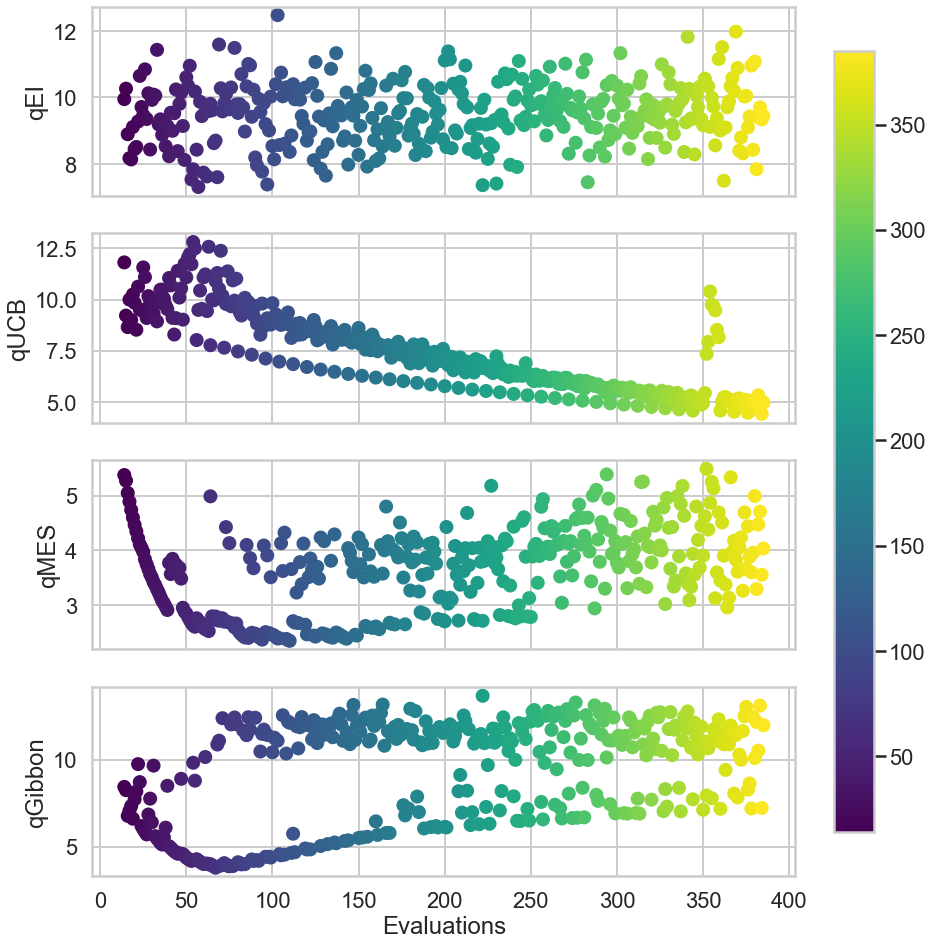

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Generating sample data for demonstration purposes
#iterations = np.linspace(1, 1900, 1200)

def mdpe(ys,init_size,d):
    
    #ite=[1,20,50,100,200,400,800,1000,1500,1600,1800,1900]
    #ite=[1,50,100,150,200,250,300,350,400,500,600,700,800,1000,1200,1500,1700]
    point_dist=[]
    ite=np.arange(14,400-14,1)
    for i in ite:
        #average pairwise distance
        points=np.array(ys.iloc[0:init_size+i,0:d])
        point=np.array(ys.iloc[init_size+i,0:d])
        #print(point)
        distances = np.linalg.norm(points - point, axis=1)
        apd=np.mean(distances)
        #dist.append(average_pairwise_distance(np.array(S), np.array(X)))
        point_dist.append(apd)
    return point_dist

d=6
init_size=14
array1=mdpe(ei_1,init_size,d)
array2=mdpe(ucb_1,init_size,d)
array3=mdpe(mes_1,init_size,d)
array4=mdpe(gibbon_1,init_size,d)


iterations = np.arange(14,400-14,1) # np.linspace(1, 14, 400-14)

print(iterations.shape, len(array1))
# Normalize the iteration values for colormap
norm_iterations = (iterations - min(iterations)) / (max(iterations) - min(iterations))
colors = plt.cm.viridis(norm_iterations)

all_values = np.concatenate((array1, array2, array3, array4))
vmin = np.min(all_values)
vmax = np.max(all_values)

plt.rcParams.update({'font.size': 40})

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

#print(iterations.shape, len(array1))
# Scatter plot for each array
axs[0].scatter(iterations, array1, c=colors, label='Array 1')
axs[0].set_ylabel('qEI')
#axs[0].set_ylim(18,33)
#axs[0].legend(bbox_to_anchor=(0.7,1))

axs[1].scatter(iterations, array2, c=colors, label='Array 2')
axs[1].set_ylabel('qUCB')
#axs[1].set_ylim(18,33)
#axs[1].legend(bbox_to_anchor=(0.7,1))

axs[2].scatter(iterations, array3, c=colors, label='Array 3')
axs[2].set_ylabel('qMES')
#axs[2].set_ylim(18,33)
#axs[2].legend(bbox_to_anchor=(0.7,1))

axs[3].scatter(iterations, array4, c=colors, label='Array 4')
axs[3].set_ylabel('qGibbon')
axs[3].set_xlabel('Evaluations')
#axs[3].set_ylim(18,33)
#axs[3].legend(bbox_to_anchor=(0.7,1))

# Adding a color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(iterations), vmax=max(iterations)))
sm.set_array([])
fig.colorbar(sm, ax=axs, orientation='vertical', fraction=.05)

plt.show()


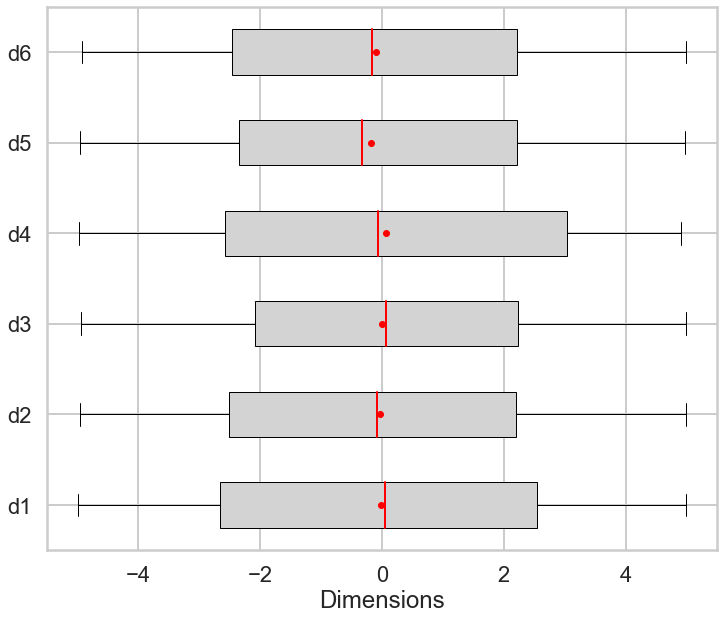

In [19]:
import numpy as np
import matplotlib.pyplot as plt

dim=6

# Generate example data (50 points in 14 dimensions)
np.random.seed(42)  # For reproducibility
#data = np.random.uniform(-5, 5, (50, 14))

plt.rcParams.update({'font.size': 40})

data= np.array(ei_1.iloc[init_size:,0:dim])
# Create a figure
plt.figure(figsize=(12,10))

# Plot box plots for each dimension
boxprops = dict(facecolor='lightgray', color='black')
medianprops = dict(color='red', linewidth=2)
meanprops = dict(marker='o', markerfacecolor='red', markeredgecolor='red')

plt.boxplot(data, patch_artist=True, boxprops=boxprops, medianprops=medianprops, showmeans=True, meanprops=meanprops,vert=False)

# Plot box plots for each dimension
#plt.boxplot(data, patch_artist=True)
#plt.title('Box Plot of Points in Each Dimension')
plt.xlabel('Dimensions')
#plt.ylabel('PCE')
plt.yticks(ticks=np.arange(1, dim+1), labels=[f'd{i}' for i in range(1, dim+1)])
plt.grid(True)
#plt.savefig('Robot_Pce.pdf',bbox_inches='tight')
#plt.savefig('/Users/nazanin/Desktop/Robot_Pce.pdf', bbox_inches='tight')
plt.show()


## Feature Importance 

In [20]:
import numpy as np
import pandas as pd 

deepa_gp=pd.read_csv('Levy_6d_DEEPA_GP.csv')
deepa_mars=pd.read_csv('Levy_6d_DEEPA_MARS.csv')
mars_fi=pd.read_csv('Levy_6d_DEEPA_MARS_FI.csv')

            0         1         2         3         4         5       f(x)
0   -3.132230  3.426070 -1.202525  1.587775 -4.421507  2.357732  12.324342
1   -4.889176  0.110881 -1.893042 -1.957540 -1.239121 -3.584471  22.866865
2    1.756347 -1.969915  0.009793 -4.129698  4.617152 -1.257802  12.981211
3    4.182906  1.365745 -3.528064  4.083198  1.377663  3.215350   8.527166
4    4.710006 -0.366970  2.410556  2.804462  3.880911 -4.610388  10.573005
..        ...       ...       ...       ...       ...       ...        ...
297  0.041881  0.980165  0.559113  0.452090  0.932786  0.522324   0.712593
298  0.992298  0.969642  0.872313  0.903712  0.705620  0.568245   0.059895
299  0.406532  0.548760  0.008104  0.019975  0.060682  0.813260   0.616695
300  0.600930  0.081414  0.503733  0.596638  0.611870  0.308997   0.455485
301  0.738406  0.575795  0.010603  0.466222  0.542955  0.491219   0.368685

[302 rows x 7 columns]
   Feature  Importance
3        4    0.651869
0        1    0.196184
4      

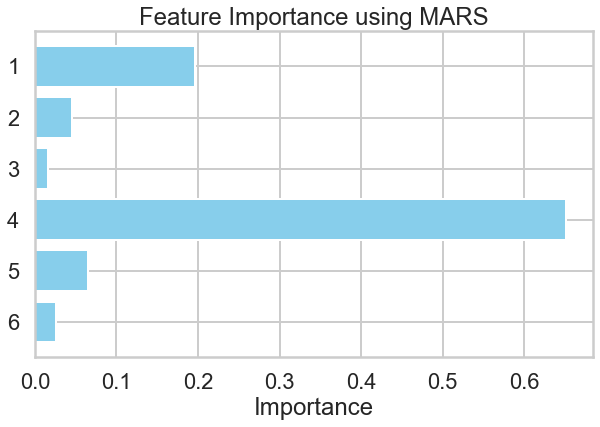

In [21]:
np.int = int
np.float = float
np.object = object
np.bool = bool

import pandas as pd
from pyearth import Earth
import matplotlib.pyplot as plt

d=6
# Load the dataset
data = deepa_gp.iloc[:,0:d+1] # Replace with your dataset file path
X = data.iloc[:, :-1]  # Features
y = -data.iloc[:, -1]   # Target

print(data)

# Fit a MARS model
model = Earth(feature_importance_type='rss') # default=None, ‘gcv’, ‘rss’ and ‘nb_subsets’. 
model.fit(X, y)

# Calculate feature importance
feature_importance = model.feature_importances_

# Get feature importances using the summary method
#feature_importance = model.summary().importance
X.columns=np.arange(1,d+1)

# Create a table showing feature importance values
feature_importance_table = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort the table based on feature importance values in descending order
feature_importance_table = feature_importance_table.sort_values(by='Importance', ascending=False)

# Display the table
print(feature_importance_table)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_table['Feature'], feature_importance_table['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance using MARS')
plt.gca().invert_yaxis()
plt.show()


In [22]:
import numpy as np
import matplotlib.pyplot as plt
# Monkey-patching deprecated NumPy aliases
np.int = int
np.float = float
np.object = object
np.bool = bool

data = deepa_gp.iloc[:,0:d+1]

N=data.shape[0]
d=6
batch_size=4
init_size=2*(d+1)
nn=int((N-init_size)/4)

print("Number of iterations:",N,nn)

f1=[]
f2=[]
f3=[]
f4=[]
f5=[]
f6=[]
f7=[]
f8=[]
f9=[]
f10=[]

for i in range(nn-1):
    Y=data.iloc[0:init_size+batch_size*(i),d]
    X=data.iloc[0:init_size+batch_size*(i),0:d]
    S=data.iloc[init_size+batch_size*(i):init_size+batch_size*(i+1),0:d]
    
    model = Earth(feature_importance_type='rss') 
    model.fit(X, Y)
    feature_importance = model.feature_importances_
    f1.append(feature_importance[0])
    f2.append(feature_importance[1])
    f3.append(feature_importance[2])
    f4.append(feature_importance[3])
    f5.append(feature_importance[4])
    f6.append(feature_importance[5])
    

Number of iterations: 302 72


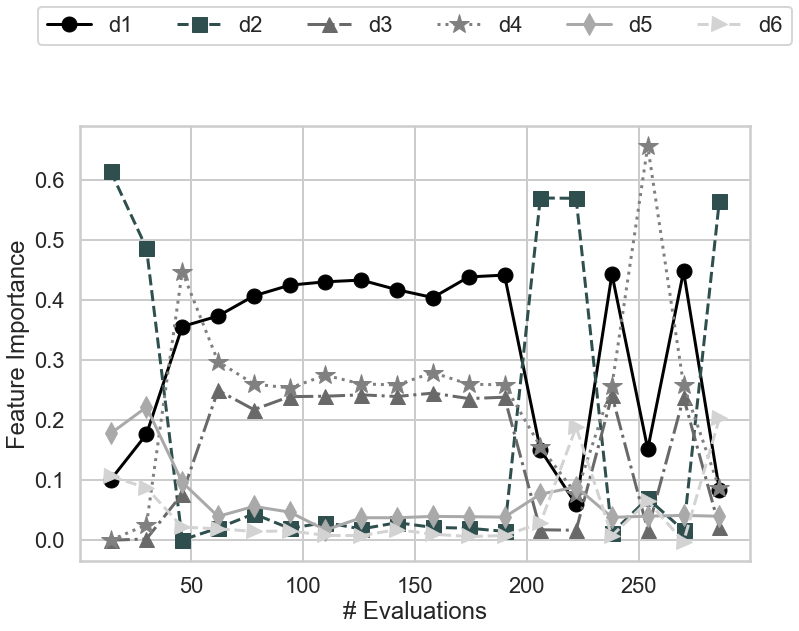

In [23]:
y1 = np.array(f1)
y2 = np.array(f2)
y3 = np.array(f3)
y4 = np.array(f4)
y5 = np.array(f5)
y6= np.array(f6)

bb=4

y1=y1[::bb]
y2=y2[::bb]
y3=y3[::bb]
y4=y4[::bb]
y5=y5[::bb]
y6=y6[::bb] 

x = np.arange(14, 300-4, 4*bb)  # start at 0, stop at 200, step by 4

# Plot the points
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 40})

C=[   "#000000",  # Black
    "#2F4F4F",  # Dark Slate Gray
    "#696969",  # Dim Gray
    "#808080",  # Gray
    "#A9A9A9",  # Dark Gray
    "#D3D3D3"   # Light Gray
]

A=1

plt.plot(x, y1, linestyle='-', marker='o', color=C[0], markersize=15, alpha=A, label='d1')
plt.plot(x, y2, linestyle='--', marker='s', color=C[1], markersize=15, alpha=A, label='d2')
plt.plot(x, y3, linestyle='-.', marker='^', color=C[2], markersize=15, alpha=A, label='d3')
plt.plot(x, y4, linestyle=':', marker='*', color=C[3],markersize=20, alpha=A, label='d4')
plt.plot(x, y5, linestyle='-', marker='d', color=C[4], markersize=15, alpha=A, label='d5')
plt.plot(x, y6, linestyle='--', marker='>', color=C[5], markersize=15, alpha=A, label='d6')

# Adding labels and title
plt.xlabel('# Evaluations')
plt.ylabel('Feature Importance')
#plt.title('Feature Importance Over Evaluations')

plt.legend(bbox_to_anchor=(0.5,1.3), ncol=6,loc='upper center')
plt.grid(True)
plt.show()

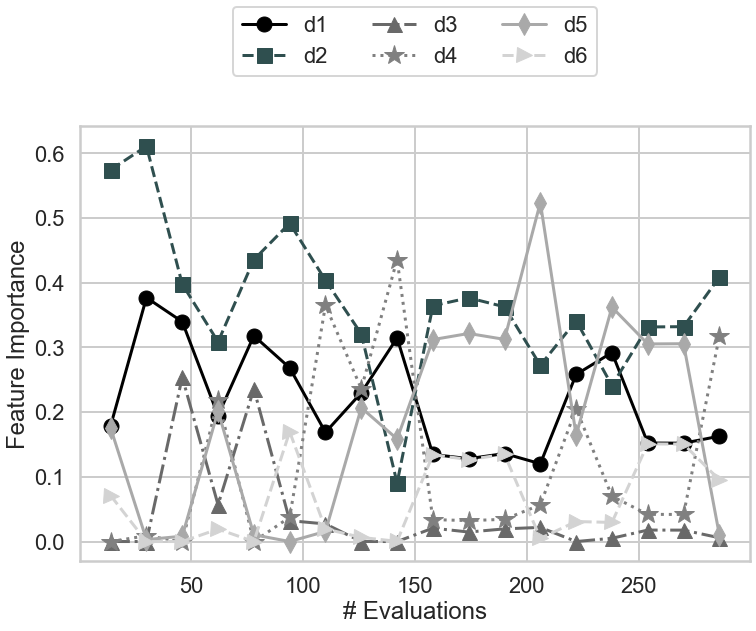

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming mars_fi is already defined and contains the data
y1 = np.array(mars_fi.iloc[:,0])
y2 = np.array(mars_fi.iloc[:,1])
y3 = np.array(mars_fi.iloc[:,2])
y4 = np.array(mars_fi.iloc[:,3])
y5 = np.array(mars_fi.iloc[:,4])
y6 = np.array(mars_fi.iloc[:,5])

#x = np.arange(14, 300, 4)  # start at 0, stop at 200, step by 4

bb=4

y1=y1[::bb]
y2=y2[::bb]
y3=y3[::bb]
y4=y4[::bb]
y5=y5[::bb]
y6=y6[::bb] 

x = np.arange(14, 300-4, 4*bb)  # start at 0, stop at 200, step by 4

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 40})

C=[   "#000000",  # Black
    "#2F4F4F",  # Dark Slate Gray
    "#696969",  # Dim Gray
    "#808080",  # Gray
    "#A9A9A9",  # Dark Gray
    "#D3D3D3"   # Light Gray
]

A=1

plt.plot(x, y1, linestyle='-', marker='o', color=C[0], markersize=15, alpha=A, label='d1')
plt.plot(x, y2, linestyle='--', marker='s', color=C[1], markersize=15, alpha=A, label='d2')
plt.plot(x, y3, linestyle='-.', marker='^', color=C[2], markersize=15, alpha=A, label='d3')
plt.plot(x, y4, linestyle=':', marker='*', color=C[3],markersize=20, alpha=A, label='d4')
plt.plot(x, y5, linestyle='-', marker='d', color=C[4], markersize=15, alpha=A, label='d5')
plt.plot(x, y6, linestyle='--', marker='>', color=C[5], markersize=15, alpha=A, label='d6')

# Adding labels and title
plt.xlabel('# Evaluations')
plt.ylabel('Feature Importance')

plt.legend(bbox_to_anchor=(0.5,1.3), ncol=3,loc='upper center')
plt.grid(True)
plt.show()

In [25]:
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from sklearn.neighbors import KernelDensity
from itertools import combinations
import pandas as pd 
import csv
import os 
wd=os.getcwd()

#Rover_60d_DEEPA_GP.csv
d=60
path=wd+'/'#+'/Rover_result1/'
Name='Rover'
# ei=pd.read_csv(path+Name+'_'+str(d)+'d_EI.csv')
# ucb=pd.read_csv(path+Name+'_'+str(d)+'d_UCB.csv')
# gibbon=pd.read_csv(path+Name+'_'+str(d)+'d_Gibbon.csv')
# mes=pd.read_csv(path+Name+'_'+str(d)+'d_MES.csv')
deepa=pd.read_csv(path+Name+'_'+str(d)+'d_DEEPA_GP.csv')
N=deepa.shape[0]
Budget=3000
batch_size=50
nn=int(N/batch_size)
init_size=2*(d+1)

## 
xx=deepa.iloc[:,0:d]
yy=deepa.iloc[:,d]
exploration=deepa.iloc[:,d+3]


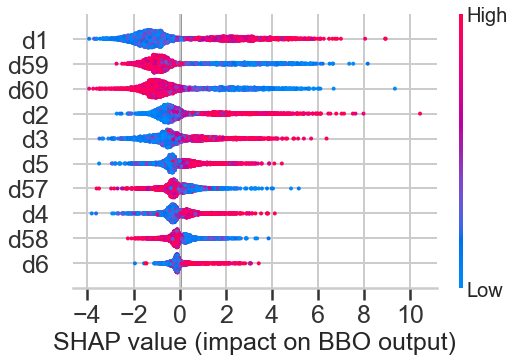

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor

plt.rcParams.update({'font.size': 35})

# Generate a synthetic dataset
X, y = np.array(xx),np.array(yy) #make_regression(n_samples=100, n_features=60, noise=0.1, random_state=42)
feature_names = [f'd{i+1}' for i in range(X.shape[1])]

# Fit a decision tree regressor
regressor = DecisionTreeRegressor()
regressor.fit(X, y)

# Compute SHAP values
explainer = shap.Explainer(regressor, X)
shap_values = explainer(X)

# Compute mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Identify top 5 and bottom 5 features
top5_indices = np.argsort(mean_shap_values)[-10:][::-1]
#bottom5_indices = np.argsort(mean_shap_values)[:5]

# Combine top 5 and bottom 5 indices
selected_indices = top5_indices #np.concatenate((top5_indices, bottom5_indices))

# Plotting
plt.figure(figsize=(16, 8))


# Bar plot for SHAP values
shap.summary_plot(shap_values[:, selected_indices], X[:, selected_indices], feature_names=[feature_names[i] for i in selected_indices], show=False)
#plt.title('Top 5 and Bottom 5 Features Based on SHAP Values')

ss=25
plt.xlabel('SHAP value (impact on BBO output)', fontsize=ss)
#plt.ylabel('Feature', fontsize=ss)
#plt.title('Top 5 and Bottom 5 Features Based on SHAP Values', fontsize=16)
#plt.legend(fontsize=ss)
plt.xticks(fontsize=ss)
plt.yticks(fontsize=ss)

#cbar=plt.colorbar()
#cbar.set_label('SHAP Value', fontsize=25)
#cbar.ax.tick_params(labelsize=25)

cbar = plt.gcf().axes[-1]  # Get the colorbar axis
cbar.tick_params(labelsize=20)  # Change the number to your desired font size
cbar.set_ylabel('') 

#plt.savefig('Rover_fibb.pdf',bbox_inches='tight')
plt.show()



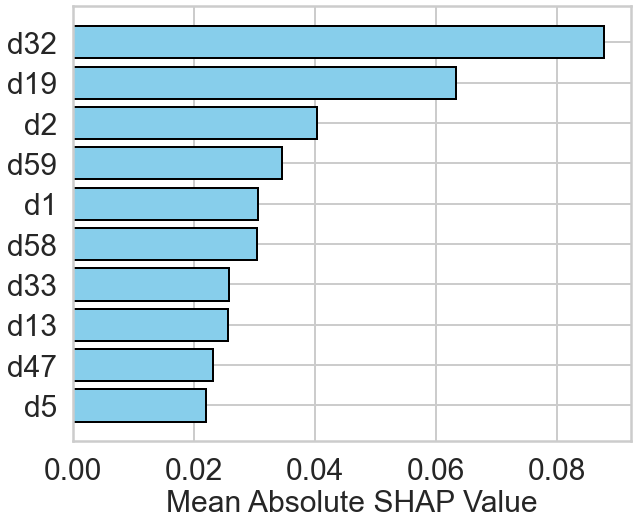

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor

# Generate a synthetic dataset with 60 features
X, y = np.array(xx),np.array(exploration)  #make_regression(n_samples=100, n_features=60, noise=0.1, random_state=42)
feature_names = [f'd{i+1}' for i in range(X.shape[1])]

# Fit a decision tree regressor
regressor = DecisionTreeRegressor()
regressor.fit(X, y)

# Compute SHAP values
explainer = shap.Explainer(regressor, X)
shap_values = explainer(X)

# Compute mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Identify top 10 features
top10_indices = np.argsort(mean_shap_values)[-10:][::-1]
top10_features = [feature_names[i] for i in top10_indices]
top10_shap_values = mean_shap_values[top10_indices]

ss=30
# Create a bar plot for the top 10 features
plt.figure(figsize=(10, 8))
plt.barh(top10_features, top10_shap_values, color='skyblue', edgecolor='black')
plt.xlabel('Mean Absolute SHAP Value', fontsize=ss)
#plt.ylabel('Feature', fontsize=14)
#plt.title('Top 10 Features Based on SHAP Values', fontsize=16)
plt.xticks(fontsize=ss)
plt.yticks(fontsize=ss)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values on top
#plt.savefig('Rover_fiee60.pdf',bbox_inches='tight')
plt.show()


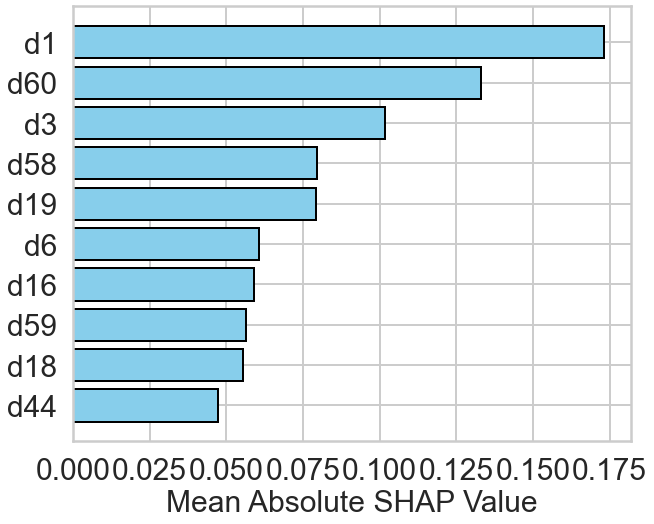

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor

# Generate a synthetic dataset with 60 features
X, y = np.array(xx.iloc[0:1000,:]),np.array(exploration.iloc[0:1000])  #make_regression(n_samples=100, n_features=60, noise=0.1, random_state=42)
feature_names = [f'd{i+1}' for i in range(X.shape[1])]

# Fit a decision tree regressor
regressor = DecisionTreeRegressor()
regressor.fit(X, y)

# Compute SHAP values
explainer = shap.Explainer(regressor, X)
shap_values = explainer(X)

# Compute mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Identify top 10 features
top10_indices = np.argsort(mean_shap_values)[-10:][::-1]
top10_features = [feature_names[i] for i in top10_indices]
top10_shap_values = mean_shap_values[top10_indices]

ss=30
# Create a bar plot for the top 10 features
plt.figure(figsize=(10, 8))
plt.barh(top10_features, top10_shap_values, color='skyblue', edgecolor='black')
plt.xlabel('Mean Absolute SHAP Value', fontsize=ss)
#plt.ylabel('Feature', fontsize=14)
#plt.title('Top 10 Features Based on SHAP Values', fontsize=16)
plt.xticks(fontsize=ss)
plt.yticks(fontsize=ss)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest values on top
#plt.savefig('Rover_fiee20.pdf',bbox_inches='tight')
plt.show()
